# Model Analysis
**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT THE NOTEBOOK**

## Step 1: Data Preprocessing
**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT THE DATA PREPROCESSING, ALL THE PARTS (DATA CLEANING/EXTENDING, SPLITTING THE DATA INTO TRAIN AND TEST, CHOOSING BETWEEN RESAMPLING AND SUBSAMPLING)**

In [1]:
# import libraries ncessary for data cleaning and extending
import pandas as pd
import numpy as np
import sqlite3

# import library for resampling data
from sklearn.utils import resample

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the matches and the predictions table from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()

In [3]:
# helper function that counts up the points of the last 5 matches
def count_points(last_5):
    # if there is no last 5 list, return 0
    if last_5 == 0:
        return 0

    # initialize a count variable
    count = 0
    # go trough all the elements of the last_5 list
    for i in last_5:
        # if the element is a win, add 3 to the count
        if i == 'W':
            count += 3
        # if the element is a tie, add 1 to the count
        elif i == 'T':
            count += 1
    return count

**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT CLEANING AND EXTENDING THE DATA. WHY DID WE ADD CERTAIN COLUMNS? HOW DID WE DO IT?**

In [4]:
# main function that cleans and extends the data
def extend_data(input_data):
    # clean the inputted dataframe
    # make a copy of the data so the original dataframe does not change
    data = input_data.copy()
    
    # drop the "time" column because it contains to many "None" values, and the "date" column because it is not used
    data.drop(columns = ['time', 'date'], inplace = True)
    
    # drop NaN values (there are only NaN values left in the "score" column)
    data.dropna(inplace = True)
    
    # create two new columns, one for the score of the home team, and one for the score of the away team, drop the score column
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data.drop(columns=['score'], inplace = True)
    
    # create a new column to show which team won (1 for home team, 2 for away team and 'X' for a draw)
    data['winner'] = data.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 2 if row['home_score'] < row['away_score'] else 'X', axis=1)


    # use the code from exercise 10 to gather more data for the matches
    # make a copy of the data dataframe so the original dataframe does not change
    data_copy = data

    # calculate, for every unique group of season, division, matchday and home_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    home_stats = data_copy.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF=('home_score', 'sum'), GA=('away_score', 'sum'),
        W=('winner', lambda x: (x == 1).sum()),
        L=('winner', lambda x: (x == 2).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'home_team': 'team', 'result': 'home_result'})

    # calculate, for every unique group of season, division, matchday and away_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    away_stats = data_copy.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF=('away_score', 'sum'), GA=('home_score', 'sum'),
        W=('winner', lambda x: (x == 2).sum()),
        L=('winner', lambda x: (x == 1).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'away_team': 'team', 'result': 'away_result'})

    
    # add the statestics for the home teams and the away teams together
    combined_stats = pd.concat([home_stats, away_stats]).fillna(0)
    # calculate the goal difference for each row, a negative goal difference means the team got more goals against then that it made
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    # calculate the amount of points for each row, a win is worth 3 points, and a tie 1
    combined_stats['Pts'] = combined_stats['W'] * 3 + combined_stats['T']
    # create a result column that contains "W" if the team one the match, 'L' if the team lost the match and "T" if the team tied the match
    combined_stats['result'] = combined_stats.apply(lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1)

    # sort the combined statistics so they are in the right order
    results = combined_stats.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'])
    # cumulative sum 'GF', 'GA', 'GD', 'W', 'L', 'T' and 'Pts', so that it is updated for every matchday
    results[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = results.groupby(['season', 'division', 'team'])[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']].cumsum()

    # sort the dataframe again so that the rank can be calculated
    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])    
    # calculate the rank
    results['rank'] = results.groupby(['season', 'division', 'matchday']).cumcount() + 1
    # sort the dataframe so everything is in the right order
    results = results.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)

    # create a column with the last 5 results of the team in the same season and division
    results['last_5'] = results.apply(lambda row: results[
        (results['season'] == row['season']) &
        (results['division'] == row['division']) &
        (results['matchday'] <= row['matchday']) &
        (results['matchday'] >= max(1, row['matchday'] - 4)) &
        (results['team'] == row['team'])
    ]['result'].tolist()[-5:], axis=1)

    # count the amount of points the last 5 results would total to
    results['last_5'] = results['last_5'].apply(lambda x: count_points(x))  
    
    # the final result dataframe
    results = results[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result', 'last_5']]

    
    # shift the results dataframe so that it can be combined with the data dataframe later
    # make a copy of the results dataframe so the original dataframe does not change
    results_shifted = results.copy()
    # shift the matchday up by 1 so that the results dataframe will merge good with the data dataframe
    results_shifted['matchday'] += 1
    
    # rename the columns so that that values are clear, the values are from just before the matchday where they are shown started
    results_shifted = results_shifted.rename(columns={
        'rank': 'prev_rank',
        'GF': 'prev_GF', 'GA': 'prev_GA', 'GD': 'prev_GD',
        'W': 'prev_W', 'L': 'prev_L', 'T': 'prev_T', 'Pts': 'prev_Pts',
        'result': 'prev_result', 'last_5': 'prev_last_5'
    })
    
    # merge the data dataframe with the shifted results dataframe, first only for the home teams
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'home_team'], 
                      right_on=['season', 'division', 'matchday', 'team']).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)
    
    # merge the data dataframe again with the shifted results dataframe, now for the away teams, and ensure the prefixes are correct
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'away_team'], 
                      right_on=['season', 'division', 'matchday', 'team'], 
                      suffixes=('_home', '_away')).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)

    
    # space to add extra data to the data dataframe or change existing data
    # change the values in the winner colum to the right values
    data['winner'] = data.apply(lambda row: 1 if row['winner'] == 1 else 2 if row['winner'] == 2 else 0, axis=1)

    # add a goal difference difference column
    data['GDD'] = (data['prev_GD_home'] - data['prev_GD_away']) / (data['matchday'] - 1)

    # add columns for the average goals made and conceded for the home team and the away team
    data['prev_GF_home_avg'] = data['prev_GF_home'] / (data['matchday'] - 1)
    data['prev_GA_home_avg'] = data['prev_GA_home'] / (data['matchday'] - 1)
    data['prev_GF_away_avg'] = data['prev_GF_away'] / (data['matchday'] - 1)
    data['prev_GA_away_avg'] = data['prev_GA_away'] / (data['matchday'] - 1)

    # add a column for the rank difference between the home and the away team
    data['prev_rank_diff'] = data['prev_rank_home'] - data['prev_rank_away']

    # add a column for the difference between the last_5 for home and away
    data['prev_last_5_diff'] = data['prev_last_5_home'] - data['prev_last_5_away']


    # don't know what these are called
    data['prev_GFH_GAA'] = (data['prev_GF_home'] - data['prev_GA_away']) / (data['matchday'] - 1)
    data['prev_GFA_GAH'] = (data['prev_GF_away'] - data['prev_GA_home']) / (data['matchday'] - 1)
    data['prev_GDH_GDA'] = (data['prev_GFH_GAA'] - data['prev_GFA_GAH']) / (data['matchday'] - 1)

    # add some columns with head to head data for each team pair
    # add a column to represent team pairs in an unordered manner, this can be used to groupby
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)
    
    # add a column for a head to head last 5 ratio (shifted 1 so the match itself is not taken into account)
    data['head_to_head_last_5'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 1) / 5, raw=True))    

    # add a column for a head to head draw ratio for the last 5 games (shifted 1 so the match itself is not taken into account)
    data['head_to_head_draw_ratio'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 'X') / 5, raw=True))

    # add a column for a head to head average goals made in the last 5 games by the home team (shifted 1 so the match itself is not taken into account)
    data['head_to_head_avg_goals_home'] = data.groupby('team_pair')['home_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean())
    
    # add a column for a head to head average goals made in the last 5 games by the away team (shifted 1 so the match itself is not taken into account)
    data['head_to_head_avg_goals_away'] = data.groupby('team_pair')['away_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean())

    # add a column for a head to head goal difference in the last 5 games (shifted 1 so the match itself is not taken into account)
    data['head_to_head_goal_diff'] = data.groupby('team_pair')[['home_score', 'away_score']].apply(
        lambda x: (x['home_score'] - x['away_score']).shift(1).rolling(5, min_periods=1).mean()).reset_index(level=0, drop=True)

    # drop the team_pair column
    data.drop(columns=['team_pair'], inplace=True)


    return data.fillna(0)


**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT CHOOSING TRAINING AND TESTING SETS. WHY DID WE CHOOSE 10 SEASONS TO TRAIN ON? WHY IS THERE 3 EXTRA SEASONS ADDED TO ALL THE DATASETS? WHY DID WE CHOOSE THE TEST DATASETS?**

In [5]:
# select the right seasons for the training and testing data
training_data = df_matches[df_matches['season'].isin(['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]
testing_data_1 = df_matches[df_matches['season'].isin(['2017-2018', '2018-2019', '2019-2020','2020-2021'])]
testing_data_2 = df_matches[df_matches['season'].isin(['1928-1929', '1929-1930', '1930-1931','1931-1932'])]
testing_data_3 = df_matches[df_matches['season'].isin(['1954-1955', '1955-1956', '1956-1957','1957-1958'])]

In [7]:
# extend the training and testing data
training_data = extend_data(training_data)
testing_data_1 = extend_data(testing_data_1)
testing_data_2 = extend_data(testing_data_2)
testing_data_3 = extend_data(testing_data_3)

KeyError: "['time', 'date'] not found in axis"

In [8]:
# function to remove the first three seasons of a dataframe
def remove_first_three_seasons(data):
    # Identify the first three unique seasons in the dataset
    first_three_seasons = data['season'].sort_values().unique()[:3]
    
    # Filter out rows that belong to these first three seasons
    filtered_data = data[~data['season'].isin(first_three_seasons)]
    
    return filtered_data

# remove the first 3 years of both datasets
training_data = remove_first_three_seasons(training_data)
testing_data_1 = remove_first_three_seasons(testing_data_1)
testing_data_2 = remove_first_three_seasons(testing_data_2)
testing_data_3 = remove_first_three_seasons(testing_data_3)

**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT CHOOSING BETWEEN RESAMPLING AND SUBSAMPLING. WHICH OPTION IS BETTER, AND WHY?**

In [9]:
# subsampling
# find the minority catagory in the winner column
minority_cat = min(training_data['winner'].value_counts()) 

# seperate each class
df_class_0 = training_data[training_data['winner'] == 0]
df_class_1 = training_data[training_data['winner'] == 1]
df_class_2 = training_data[training_data['winner'] == 2]

# subsample for each class if necessary
df_class_0_subsampled = df_class_0.sample(minority_cat, random_state=42)
df_class_1_subsampled = df_class_1.sample(minority_cat, random_state=42)
df_class_2_subsampled = df_class_2.sample(minority_cat, random_state=42)

# concat each class into a final balanced training dataset
balanced_training_data_subsampled = pd.concat([df_class_0_subsampled, df_class_1_subsampled, df_class_2_subsampled]).reset_index(drop=True)

In [10]:
# resampling
# find the majority catagory in the winner column
majority_cat = max(training_data['winner'].value_counts()) 

# seperate each class
df_class_0 = training_data[training_data['winner'] == 0]
df_class_1 = training_data[training_data['winner'] == 1]
df_class_2 = training_data[training_data['winner'] == 2]

# resample for each class if necessary
df_class_0_resampled = resample(df_class_0, replace=True, n_samples=majority_cat, random_state=42)
df_class_1_resampled = resample(df_class_1, replace=True, n_samples=majority_cat, random_state=42)
df_class_2_resampled = resample(df_class_2, replace=True, n_samples=majority_cat, random_state=42)

# concat each class into a final balanced training dataset
balanced_training_data_resampled = pd.concat([df_class_0_resampled, df_class_1_resampled, df_class_2_resampled]).reset_index(drop=True)

## Step 2: Feature Selection
**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT THE FEATURE SELECTION, ALL THE PARTS (PLOTTING THE IMPORTANCE OF FEATURES, RANDOMLY SELECTING A SUBSET OF FEATURES)**

In [11]:
# import libraries necesarry for plotting the importance of features
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

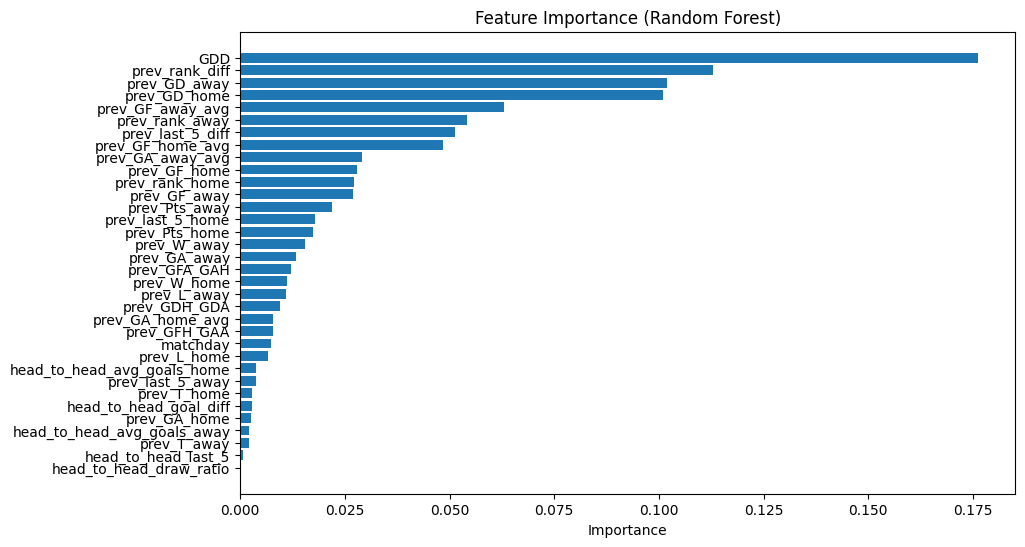

In [12]:
# select X, being all the numerical features available in the training dataset except some columns
X = balanced_training_data_subsampled.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season', 'home_score', 'away_score']).select_dtypes(include=[np.number])
# select y being the target that we try to predict (winner)
y = balanced_training_data_subsampled["winner"]

# fit a random forest classifier to find the importance of each of the features in X
rf_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1)
rf_model.fit(X, y)

# get the feature importance from the random forest classifier and put them into a dataframe for easy plotting
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [122]:
target = ['winner']
y_train = balanced_training_data_subsampled[target].values.ravel()
y_test = testing_data_1[target].values.ravel()


accuracy_total_list = []
features_list = []

# Parameters for randomized search
num_combinations = 1000  # Number of random subsets to try
min_features = 5       # Minimum number of features in a subset
max_features = 9       # Maximum number of features in a subset

all_features = feature_importance_df['Feature'].to_list()[0:20]
for i in range(num_combinations):
    print(i)
    # Randomly select a subset of features
    num_features = np.random.randint(min_features, max_features + 1)
    feature_subset = sample(list(all_features), num_features)

    features_list.append(feature_subset)
    
    X_train = X[feature_subset]
    X_test = testing_data_1[feature_subset]
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1), 
        "Support Vector Machine": SVC(kernel="linear"),
        "Naive Bayes Gaussian": GaussianNB()
    }

    accuracy_list = []
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Classification report
        report = classification_report(y_test, y_pred, target_names=["Tie (0)", "Home Win (1)", "Away Win (2)"], output_dict=True)
        accuracy_list.append(report['accuracy'])

    accuracy_total_list.append(accuracy_list)

print(accuracy_total_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

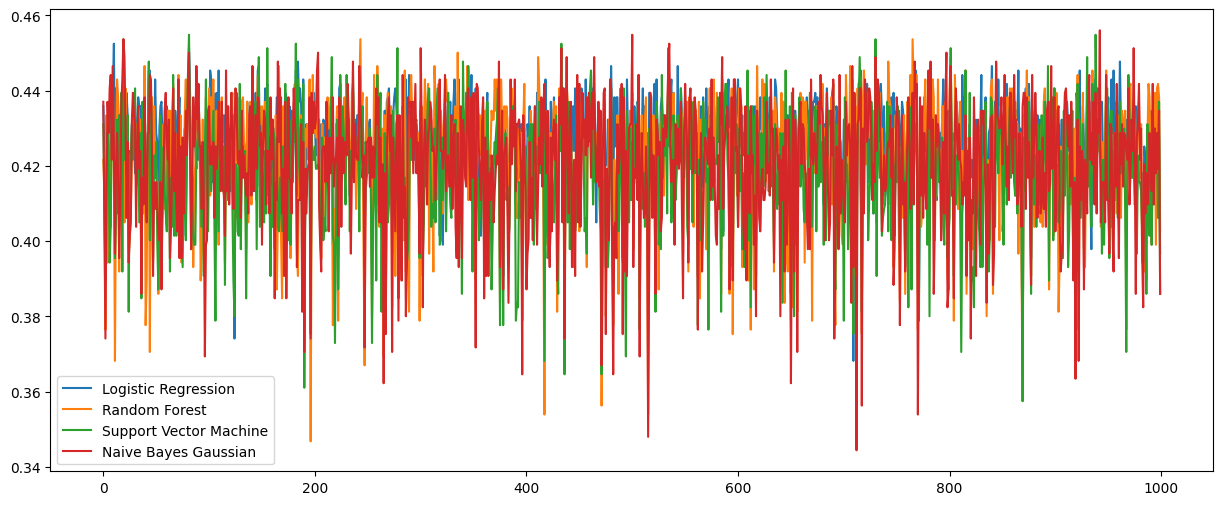

In [128]:
plt.figure(figsize=(15,6))
plt.plot(accuracy_total_list, label = ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Naive Bayes Gaussian'])
plt.legend()
plt.show()

In [133]:
top_accuracies = []  # List to store the top 5 accuracies and their iterations

for i in range(len(accuracy_total_list)):
    for accuracy in accuracy_total_list[i]:
        # Add the accuracy and iteration to the list
        top_accuracies.append((accuracy, i))
        
        # Keep only the top 5 highest accuracies by sorting and slicing
        top_accuracies = sorted(top_accuracies, reverse=True, key=lambda x: x[0])[:5]

# Display the top 5 accuracies and their iterations
for rank, (acc, iter) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {iter}")


Rank 1: Accuracy = 0.45605700712589076, Iteration = 942
Rank 2: Accuracy = 0.45486935866983375, Iteration = 81
Rank 3: Accuracy = 0.45486935866983375, Iteration = 500
Rank 4: Accuracy = 0.45486935866983375, Iteration = 938
Rank 5: Accuracy = 0.45368171021377673, Iteration = 19


In [134]:
print(best_iteration)
print(highest_accuracy)
print(features_list[best_iteration])

942
0.45605700712589076
['prev_GFA_GAH', 'head_to_head_avg_goals_away', 'prev_GA_away_avg', 'prev_GDH_GDA', 'prev_GD_home', 'prev_rank_diff', 'prev_rank_away']


## Step 3: Model Comparison
**TO-DO**<br>
**WRITE SOMETHING HERE ABOUT THE MODAL COMPARISON. WHICH MODELS WILL WE COMPARE AND WHY? WHICH ONE HAS THE BEST RESULT AND WILL WE IMPLEMENT IN THE FINAL PRODUCT?**

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Rank 1: Accuracy = 0.45605700712589076, Iteration = 942
Logistic Regression
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.26      0.30       241
           1       0.51      0.47      0.49       358
           2       0.40      0.56      0.46       243

    accuracy                           0.43       842
   macro avg       0.42      0.43      0.42       842
weighted avg       0.44      0.43      0.43       842



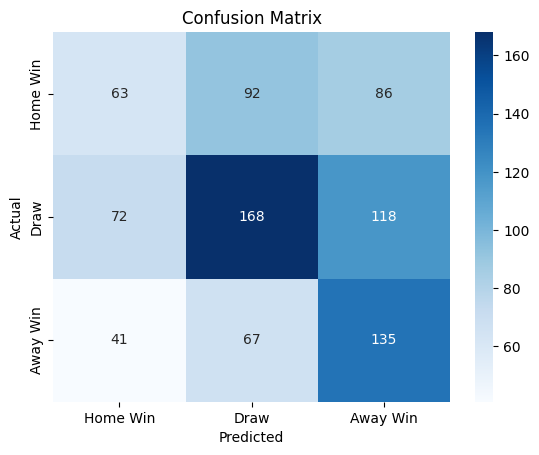

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.27      0.29       241
           1       0.51      0.53      0.52       358
           2       0.41      0.47      0.44       243

    accuracy                           0.44       842
   macro avg       0.42      0.42      0.42       842
weighted avg       0.43      0.44      0.43       842



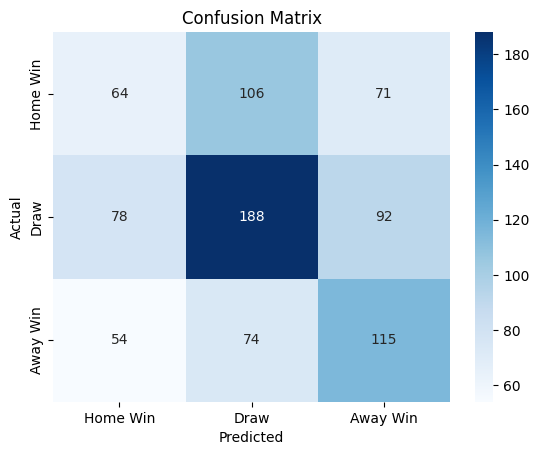

Support Vector Machine
Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.22      0.27       241
           1       0.50      0.46      0.48       358
           2       0.39      0.57      0.46       243

    accuracy                           0.42       842
   macro avg       0.41      0.42      0.40       842
weighted avg       0.42      0.42      0.41       842



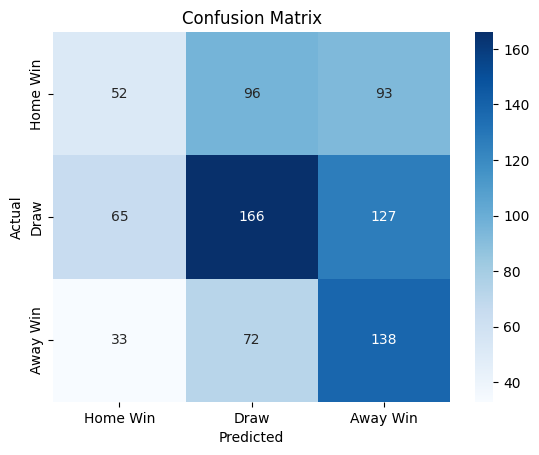

Naive Bayes Gaussian
Accuracy: 0.46
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.16      0.23       241
           1       0.49      0.62      0.55       358
           2       0.42      0.51      0.46       243

    accuracy                           0.46       842
   macro avg       0.44      0.43      0.41       842
weighted avg       0.45      0.46      0.43       842



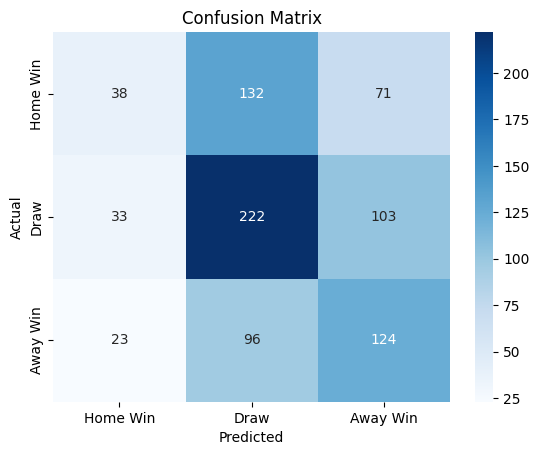

Rank 2: Accuracy = 0.45486935866983375, Iteration = 81
Logistic Regression
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.22      0.27       241
           1       0.51      0.59      0.55       358
           2       0.41      0.49      0.45       243

    accuracy                           0.45       842
   macro avg       0.43      0.43      0.42       842
weighted avg       0.44      0.45      0.44       842



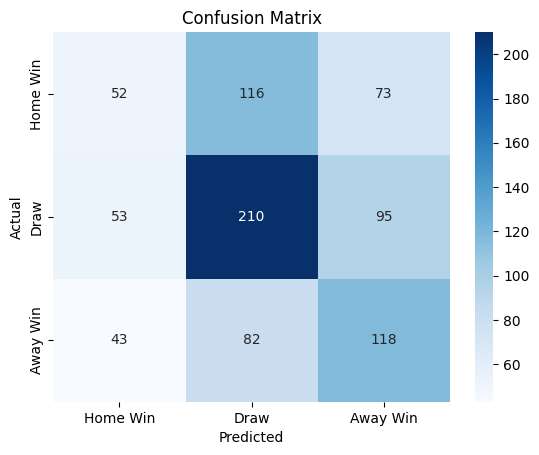

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.38      0.35       241
           1       0.51      0.52      0.51       358
           2       0.47      0.38      0.42       243

    accuracy                           0.44       842
   macro avg       0.43      0.43      0.43       842
weighted avg       0.44      0.44      0.44       842



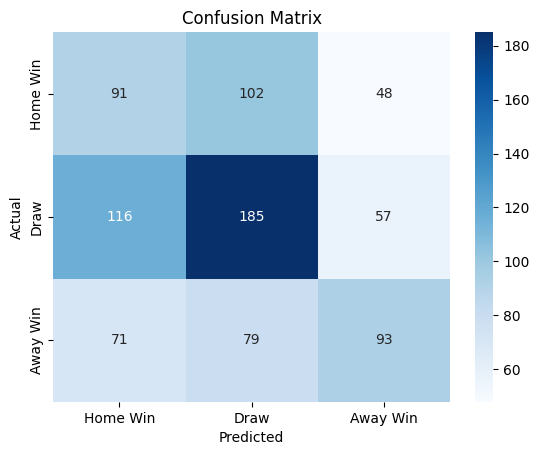

Support Vector Machine
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.23      0.29       241
           1       0.52      0.58      0.55       358
           2       0.41      0.49      0.45       243

    accuracy                           0.45       842
   macro avg       0.43      0.43      0.43       842
weighted avg       0.45      0.45      0.44       842



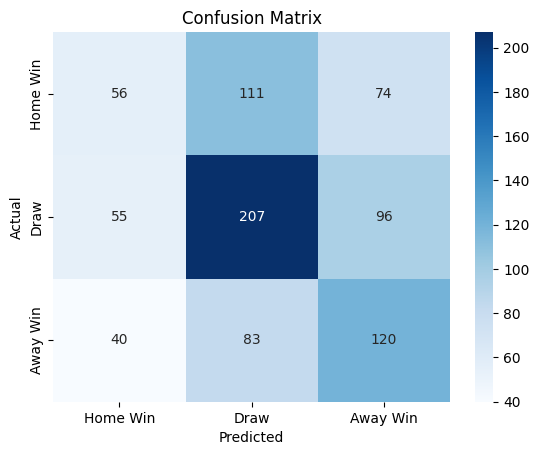

Naive Bayes Gaussian
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.38      0.36       241
           1       0.52      0.56      0.54       358
           2       0.45      0.37      0.40       243

    accuracy                           0.45       842
   macro avg       0.44      0.43      0.43       842
weighted avg       0.45      0.45      0.45       842



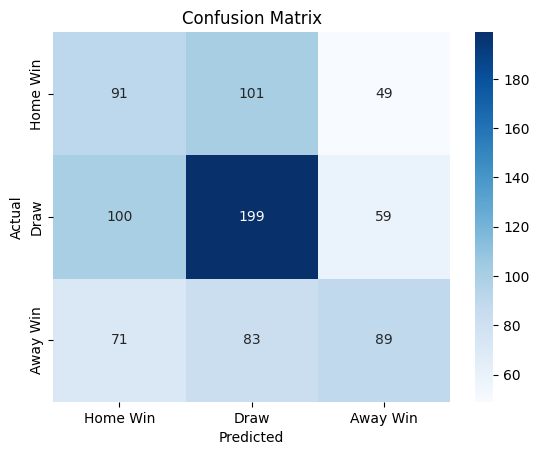

Rank 3: Accuracy = 0.45486935866983375, Iteration = 500
Logistic Regression
Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.32      0.30       241
           1       0.52      0.51      0.52       358
           2       0.43      0.39      0.41       243

    accuracy                           0.42       842
   macro avg       0.41      0.41      0.41       842
weighted avg       0.43      0.42      0.42       842



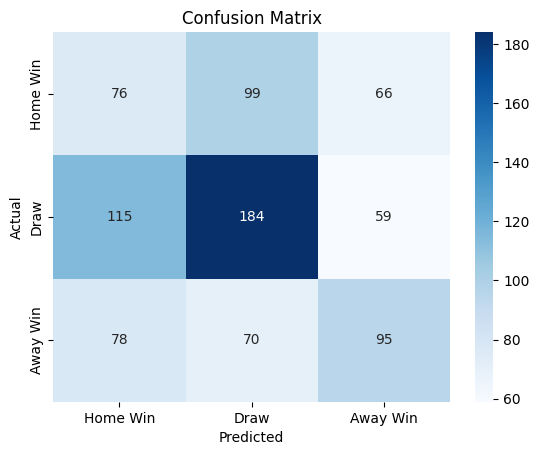

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.41      0.36       241
           1       0.51      0.52      0.52       358
           2       0.47      0.35      0.40       243

    accuracy                           0.44       842
   macro avg       0.44      0.43      0.43       842
weighted avg       0.45      0.44      0.44       842



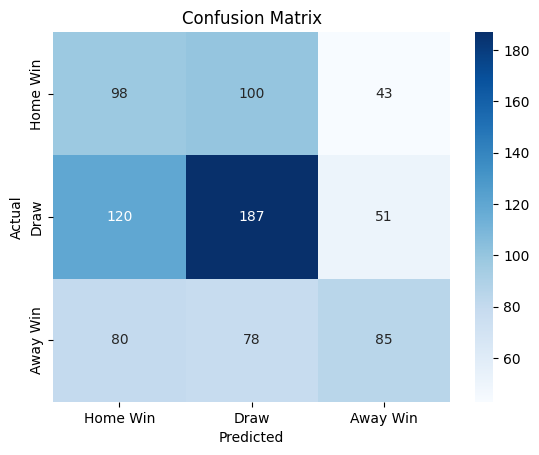

Support Vector Machine
Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.43      0.36       241
           1       0.51      0.49      0.50       358
           2       0.49      0.34      0.40       243

    accuracy                           0.43       842
   macro avg       0.44      0.42      0.42       842
weighted avg       0.45      0.43      0.43       842



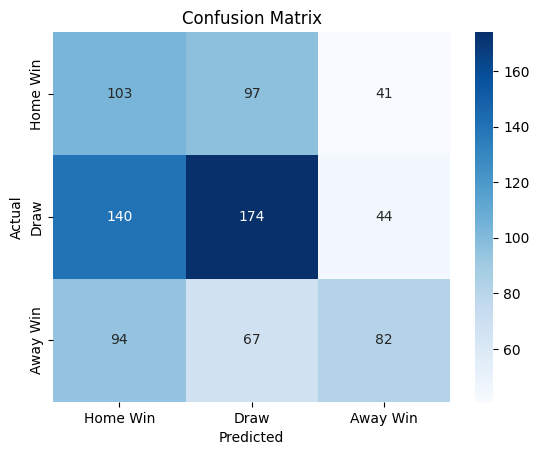

Naive Bayes Gaussian
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.22      0.27       241
           1       0.50      0.61      0.55       358
           2       0.44      0.45      0.45       243

    accuracy                           0.45       842
   macro avg       0.43      0.43      0.42       842
weighted avg       0.44      0.45      0.44       842



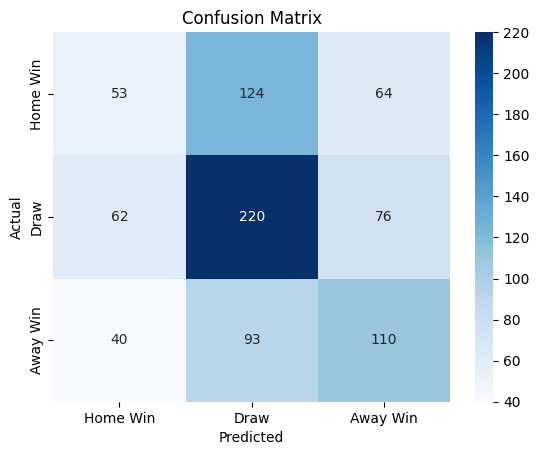

Rank 4: Accuracy = 0.45486935866983375, Iteration = 938
Logistic Regression
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25       241
           1       0.50      0.58      0.54       358
           2       0.41      0.49      0.45       243

    accuracy                           0.44       842
   macro avg       0.42      0.42      0.41       842
weighted avg       0.43      0.44      0.43       842



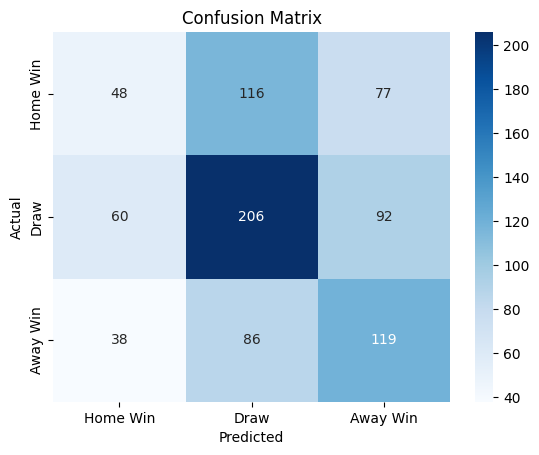

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.37      0.34       241
           1       0.51      0.52      0.51       358
           2       0.48      0.37      0.42       243

    accuracy                           0.44       842
   macro avg       0.43      0.42      0.42       842
weighted avg       0.44      0.44      0.44       842



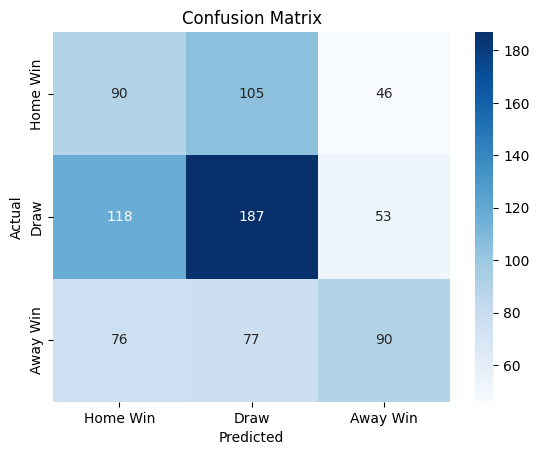

Support Vector Machine
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.26      0.30       241
           1       0.52      0.58      0.55       358
           2       0.42      0.47      0.44       243

    accuracy                           0.45       842
   macro avg       0.43      0.44      0.43       842
weighted avg       0.45      0.45      0.45       842



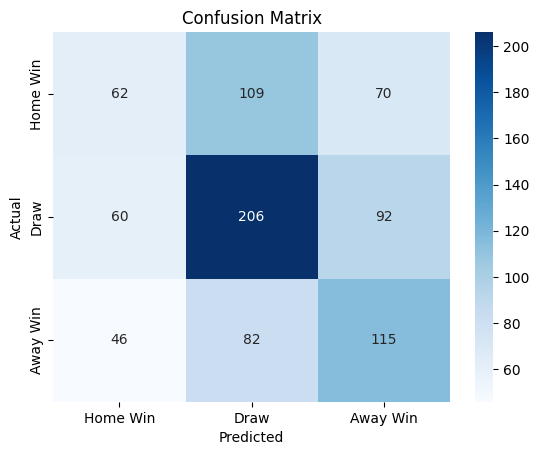

Naive Bayes Gaussian
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.14      0.19       241
           1       0.47      0.68      0.56       358
           2       0.46      0.39      0.42       243

    accuracy                           0.44       842
   macro avg       0.40      0.40      0.39       842
weighted avg       0.41      0.44      0.41       842



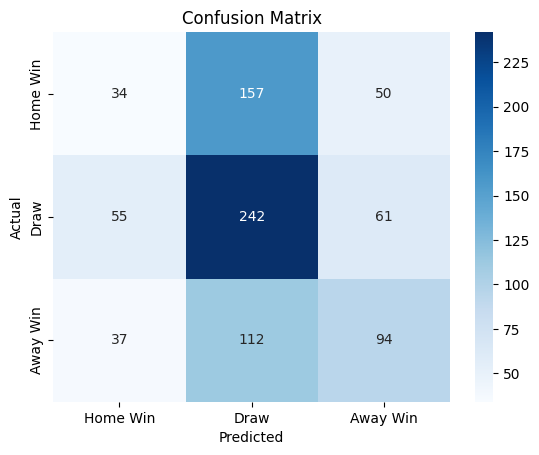

Rank 5: Accuracy = 0.45368171021377673, Iteration = 19
Logistic Regression
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.29      0.32       241
           1       0.53      0.53      0.53       358
           2       0.43      0.49      0.46       243

    accuracy                           0.45       842
   macro avg       0.43      0.44      0.43       842
weighted avg       0.45      0.45      0.45       842



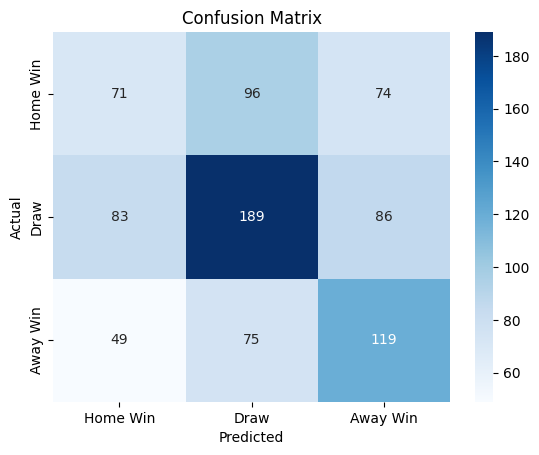

Random Forest
Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.46      0.39       241
           1       0.52      0.48      0.50       358
           2       0.47      0.35      0.40       243

    accuracy                           0.44       842
   macro avg       0.44      0.43      0.43       842
weighted avg       0.45      0.44      0.44       842



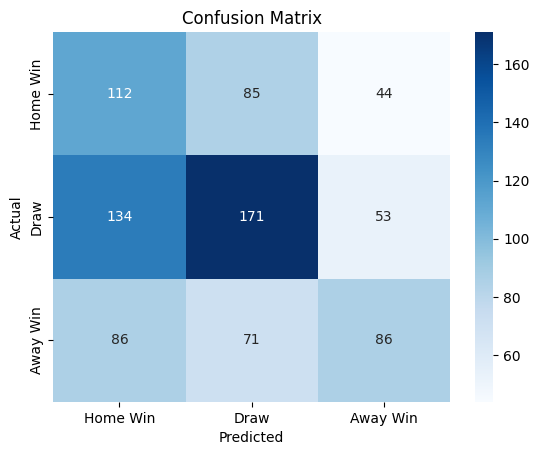

Support Vector Machine
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.29      0.32       241
           1       0.51      0.55      0.53       358
           2       0.44      0.47      0.45       243

    accuracy                           0.45       842
   macro avg       0.44      0.44      0.44       842
weighted avg       0.45      0.45      0.45       842



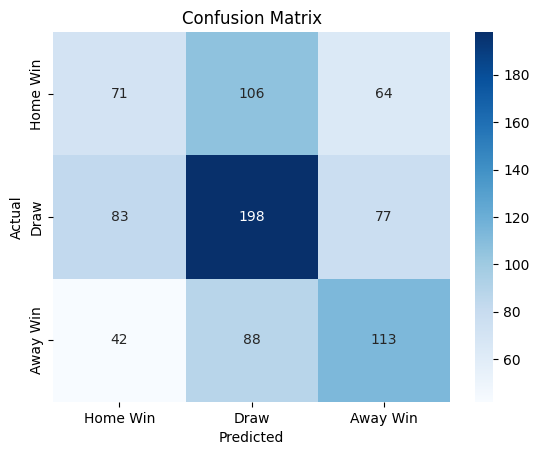

Naive Bayes Gaussian
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.19      0.24       241
           1       0.49      0.67      0.57       358
           2       0.45      0.40      0.42       243

    accuracy                           0.45       842
   macro avg       0.42      0.42      0.41       842
weighted avg       0.43      0.45      0.43       842



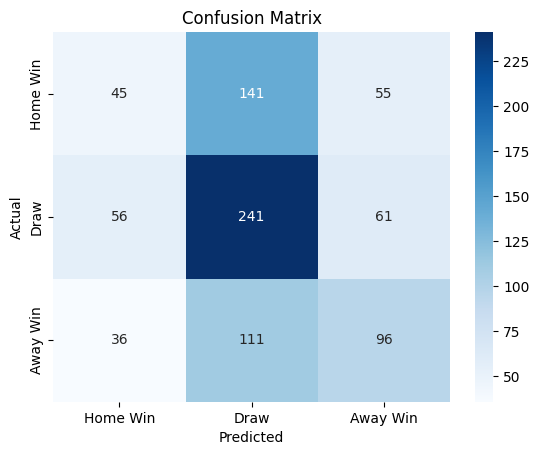

In [135]:
# features = ['GDD','prev_rank_home','prev_rank_away','prev_rank_diff','prev_GD_home','prev_GD_away','prev_last_5_diff']


for rank, (acc, best_iteration) in enumerate(top_accuracies, start=1):
    print(f"Rank {rank}: Accuracy = {acc}, Iteration = {best_iteration}")
    
    features = features_list[best_iteration]
    target = ['winner']
    
    X_train = balanced_training_data_subsampled[features]
    y_train = balanced_training_data_subsampled[target].values.ravel()
    X_test = testing_data_1[features]
    y_test = testing_data_1[target].values.ravel()
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=3, random_state=1), 
        "Support Vector Machine": SVC(kernel="linear"),
        "Naive Bayes Gaussian": GaussianNB()
    }
    
    # Train and evaluate each model
    for name, model in models.items():
        print(name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.2f}')
        
        # Classification report
        print("Classification Report:\n", classification_report(y_test, y_pred))
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()